In [1]:
import torch
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# PyTorch devices
device_swin = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_cpu = torch.device('cpu')


2026-01-13 11:53:27.313425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 11:53:28.555808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re

import h5py
from scipy.ndimage import zoom

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns #import automapRecon
import unrolling_fns
import swin_fns



/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
plt.rc('font', size=9)

## Importing fastMRI data and downsampling

The downsampled FastMRI data was saved externally to save processing time, it can be regenerated by uncommenting the following block of code

In [4]:
# loading previously downsampled fast MRI data
#inputfile = 'data/fastmri_75_64_25_train_1.npz'
inputfile = 'data/fastmri/fastmri_75_64_25_val_all.npz'
data = np.load(inputfile)

In [5]:
ksp_fs_sc_all = data['ksp_fs_sc_all']
ksp_us_sc_all = data['ksp_us_sc_all']
img_gt_sc_all = data['img_gt_sc_all']

In [6]:
ksp_fs_sc_all.shape

(1, 75, 64, 25, 1378)

In [7]:
img_gt_sc_all.shape

(75, 64, 25, 1378)

In [8]:
# comment out unneeded code block below

#quick run to generate images at high/low SNR
noise_dB = np.array([60,70,80])
n_ex_cs = 3
n_ex_test = 2

#full run to generate manuscript plots - see .py file for executed code
# noise_dB = np.arange(50,92,2)
# n_ex_cs = 10
# n_ex_test = 500

noise_dB_zero = noise_dB - 40

In [9]:
noise_dB_zero

array([20, 30, 40])

In [10]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=2
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)

mask_R2 = mask

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

In [11]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'

elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'

In [12]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))

In [13]:
import time


In [14]:
def process_jk(args):
    j, k, noise_val, ksp_fs_sc_all, img_gt_sc_all, mask, mps, calib_size = args
    
    kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
    volumeGTscaled = img_gt_sc_all[:,:,:,k]
    
    kspInput = awgn(kspTestScaled, noise_val, L=1)
    uskspace = applyMask(kspInput, mask)

    lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps, calib_size, show_plot=False)
    iter_opt = find_iter_mask(uskspace, volumeGTscaled, lamda_opt, mps, show_plot=False)

    return j, k, lamda_opt, iter_opt

In [15]:
start = time.time()

job_args = []
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        job_args.append((j, k, noise_val, ksp_fs_sc_all, img_gt_sc_all, mask, mps, calib_size))

from joblib import Parallel, delayed

results = Parallel(n_jobs=10)(
    delayed(process_jk)(args) for args in job_args
)

lamda_opt_vals = np.zeros((len(noise_dB), n_ex_cs))
iter_opt_vals = np.zeros((len(noise_dB), n_ex_cs))

for j, k, lamda_opt, iter_opt in results:
    lamda_opt_vals[j, k] = lamda_opt
    iter_opt_vals[j, k] = iter_opt

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

end = time.time()    
print(f"Took {end - start:.2f} seconds")


/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerW

Took 158.72 seconds


In [16]:
# Print in a clean aligned table
print("Noise (dB)   Lambda_opt        Iter_opt")
print("------------------------------------------")
for j, noise_val in enumerate(noise_dB_zero):
    print(f"{noise_val:8.1f}   {lamda_opt[j]:12.4f}   {iter_opt[j]:10.2f}")

Noise (dB)   Lambda_opt        Iter_opt
------------------------------------------
    20.0         0.1000         6.67
    30.0         0.0083        53.33
    40.0         0.0083        83.33


In [17]:
# Initialize metric arrays
nrmse_ifft_vals   = np.zeros((noise_dB.size, n_ex_test))
nrmse_cs_vals     = np.zeros((noise_dB.size, n_ex_test))
nrmse_amap_vals   = np.zeros((noise_dB.size, n_ex_test))
nrmse_unroll_vals = np.zeros((noise_dB.size, n_ex_test))
nrmse_swin_vals   = np.zeros((noise_dB.size, n_ex_test))

ssim_ifft_vals   = np.zeros((noise_dB.size, n_ex_test))
ssim_cs_vals     = np.zeros((noise_dB.size, n_ex_test))
ssim_amap_vals   = np.zeros((noise_dB.size, n_ex_test))
ssim_unroll_vals = np.zeros((noise_dB.size, n_ex_test))
ssim_swin_vals   = np.zeros((noise_dB.size, n_ex_test))

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
#with tf.device('/CPU:0'):
num_params = sum(p.numel() for p in model_swin.parameters() if p.requires_grad)
print(f"Swin trainable parameters: {num_params:,}")


model_real = keras.models.load_model(model_real_dir)
model_imag = keras.models.load_model(model_imag_dir)

trainable_params = np.sum([np.prod(v.shape) for v in model_real.trainable_weights])
print(f"AUTOMAP trainable parameters: {trainable_params:,}")


import time
# Evaluation loop
for j, noise_val in enumerate(noise_dB):
    print(j)
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:, :, :, :, k + n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:, :, :, k + n_ex_cs]

        # Add noise and apply mask
        kspInput = awgn(kspTestScaled, noise_val, L=1)
        uskspace = applyMask(kspInput, mask)

        # Reconstructions

        # Zer-filled Recon
        volifftrecon_mc = sp.ifft(uskspace, axes=[1, 2, 3])
        volifftrecon = coil_combine(volifftrecon_mc, mps)

        # L1-Wavelet CS Recon
        start = time.time()
        volcsrecon = ulfl1recon(uskspace, mask, lamda_opt[j], iter_opt[j], mps)
        end = time.time()
        #print(f"[{j}, {k}] CS Recon took {end - start:.2f} seconds")
        
        # Unrolled Recon
        start = time.time()
        _, volunrollrecon = unrolling_fns.unrollingRecon(uskspace, mask, mps, unroll_model_pth)
        end = time.time()
        #print(f"[{j}, {k}] Unrolled Recon took {end - start:.2f} seconds")
        
        # AUTOMAP Recon
        start = time.time()
        #volamaprecon, _ = automap_fns.automapRecon(uskspace, mps, model_real_dir, model_imag_dir)
        volamaprecon, _ = automap_fns.automapRecon(uskspace, mps, model_real, model_imag)
        end = time.time()
        #print(f"[{j}, {k}] AUTOMAP Recon took {end - start:.2f} seconds")
        
        # Swin Transformer Recon
        start = time.time()
        with torch.no_grad():
            vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)
        end = time.time()
        #print(f"[{j}, {k}] Swin Recon took {end - start:.2f} seconds")

        
        
        # Mask out background before metric calculations
        mask_metrics = np.ma.getmask(np.ma.masked_less(np.abs(volumeGTscaled), 0.05))
        volumeGTscaled[mask_metrics]    = 0
        volifftrecon[mask_metrics]      = 0
        volcsrecon[mask_metrics]        = 0
        volamaprecon[mask_metrics]      = 0
        volunrollrecon[mask_metrics]    = 0
        vol_swin[mask_metrics]          = 0

        # Compute NRMSE
        nrmse_ifft_vals[j, k]   = nrmse(np.abs(volifftrecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_cs_vals[j, k]     = nrmse(np.abs(volcsrecon[:, :, 1:]),     np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_amap_vals[j, k]   = nrmse(np.abs(volamaprecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_unroll_vals[j, k] = nrmse(np.abs(volunrollrecon[:, :, 1:]), np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_swin_vals[j, k]   = nrmse(np.abs(vol_swin[:, :, 1:]),       np.abs(volumeGTscaled[:, :, 1:]))

        # Compute SSIM
        ssim_ifft_vals[j, k]   = ssim(np.abs(volifftrecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        ssim_cs_vals[j, k]     = ssim(np.abs(volcsrecon[:, :, 1:]),     np.abs(volumeGTscaled[:, :, 1:]))
        ssim_amap_vals[j, k]   = ssim(np.abs(volamaprecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        ssim_unroll_vals[j, k] = ssim(np.abs(volunrollrecon[:, :, 1:]), np.abs(volumeGTscaled[:, :, 1:]))
        ssim_swin_vals[j, k]   = ssim(np.abs(vol_swin[:, :, 1:]),       np.abs(volumeGTscaled[:, :, 1:]))


/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Swin trainable parameters: 8,335,032


2026-01-13 11:56:56.359402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43453 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6
2026-01-13 11:56:56.365382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47006 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1a:00.0, compute capability: 7.5


AUTOMAP trainable parameters: 21,925,360
0


2026-01-13 11:59:56.984660: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1
2


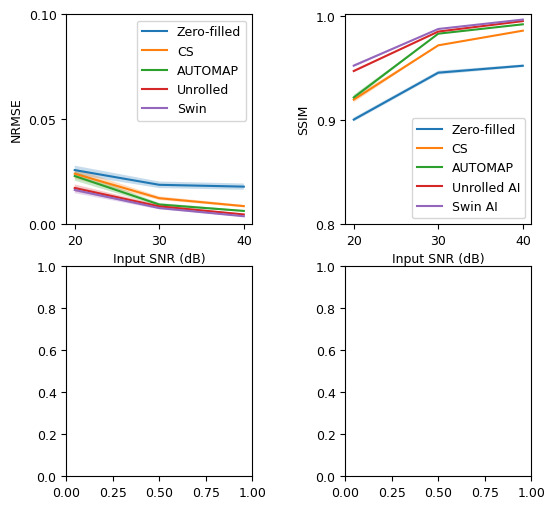

In [18]:
# Compute means
nrmse_swin   = nrmse_swin_vals.mean(axis=1)
ssim_swin    = ssim_swin_vals.mean(axis=1)

# Compute standard deviations
nrmse_swin_sd = nrmse_swin_vals.std(axis=1)
ssim_swin_sd  = ssim_swin_vals.std(axis=1)

# Existing stats (unchanged)
nrmse_cs     = nrmse_cs_vals.mean(axis=1)
nrmse_ifft   = nrmse_ifft_vals.mean(axis=1)
nrmse_amap   = nrmse_amap_vals.mean(axis=1)
nrmse_unroll = nrmse_unroll_vals.mean(axis=1)

nrmse_cs_sd     = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd   = nrmse_ifft_vals.std(axis=1)
nrmse_amap_sd   = nrmse_amap_vals.std(axis=1)
nrmse_unroll_sd = nrmse_unroll_vals.std(axis=1)

ssim_cs     = ssim_cs_vals.mean(axis=1)
ssim_ifft   = ssim_ifft_vals.mean(axis=1)
ssim_amap   = ssim_amap_vals.mean(axis=1)
ssim_unroll = ssim_unroll_vals.mean(axis=1)

ssim_cs_sd     = ssim_cs_vals.std(axis=1)
ssim_ifft_sd   = ssim_ifft_vals.std(axis=1)
ssim_amap_sd   = ssim_amap_vals.std(axis=1)
ssim_unroll_sd = ssim_unroll_vals.std(axis=1)

# Plot
fig, ((ax1, ax3),(ax2, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
fig.subplots_adjust(wspace=0.5)

# --- NRMSE Plot ---
ax1.plot(noise_dB_zero, nrmse_ifft,   '-')
ax1.plot(noise_dB_zero, nrmse_cs,     '-')
ax1.plot(noise_dB_zero, nrmse_amap,   '-')
ax1.plot(noise_dB_zero, nrmse_unroll, '-')
ax1.plot(noise_dB_zero, nrmse_swin,   '-')

ax1.set(ylabel='NRMSE', xlabel='Input SNR (dB)')
ax1.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled', 'Swin'])
ax1.fill_between(noise_dB_zero, nrmse_ifft - nrmse_ifft_sd,   nrmse_ifft + nrmse_ifft_sd,   alpha=0.25)
ax1.fill_between(noise_dB_zero, nrmse_cs - nrmse_cs_sd,       nrmse_cs + nrmse_cs_sd,       alpha=0.25)
ax1.fill_between(noise_dB_zero, nrmse_amap - nrmse_amap_sd,   nrmse_amap + nrmse_amap_sd,   alpha=0.25)
ax1.fill_between(noise_dB_zero, nrmse_unroll - nrmse_unroll_sd, nrmse_unroll + nrmse_unroll_sd, alpha=0.25)
ax1.fill_between(noise_dB_zero, nrmse_swin - nrmse_swin_sd,   nrmse_swin + nrmse_swin_sd,   alpha=0.25)
ax1.set_xticks(np.arange(noise_dB_zero[0], noise_dB_zero[-1]+10, 10))
ax1.set_yticks([0, 0.05, 0.1])

# --- SSIM Plot ---
ax3.plot(noise_dB_zero, ssim_ifft,   '-')
ax3.plot(noise_dB_zero, ssim_cs,     '-')
ax3.plot(noise_dB_zero, ssim_amap,   '-')
ax3.plot(noise_dB_zero, ssim_unroll, '-')
ax3.plot(noise_dB_zero, ssim_swin,   '-')

ax3.set(ylabel='SSIM', xlabel='Input SNR (dB)')
ax3.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled AI', 'Swin AI'])
ax3.fill_between(noise_dB_zero, ssim_ifft - ssim_ifft_sd,   ssim_ifft + ssim_ifft_sd,   alpha=0.25)
ax3.fill_between(noise_dB_zero, ssim_cs - ssim_cs_sd,       ssim_cs + ssim_cs_sd,       alpha=0.25)
ax3.fill_between(noise_dB_zero, ssim_amap - ssim_amap_sd,   ssim_amap + ssim_amap_sd,   alpha=0.25)
ax3.fill_between(noise_dB_zero, ssim_unroll - ssim_unroll_sd, ssim_unroll + ssim_unroll_sd, alpha=0.25)
ax3.fill_between(noise_dB_zero, ssim_swin - ssim_swin_sd,   ssim_swin + ssim_swin_sd,   alpha=0.25)
ax3.set_xticks(np.arange(noise_dB_zero[0], noise_dB_zero[-1]+10, 10))
ax3.set_yticks([0.8, 0.9, 1])

# Save or show as needed
# fig.savefig('export_figs/fastmri_noise_curves_R'+str(R)+'.pdf', bbox_inches='tight', dpi=300)


## Low SNR

In [19]:
test_no = 125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l = 0
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [20]:
noise_val

60

In [21]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask, mps, unroll_model_pth)
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale


model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)

### Background Masked

In [22]:
model_real_dir

'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras'

In [23]:
vol_swin.shape

(75, 64, 25)

In [24]:
volunrollrecon.shape

(75, 64, 25)

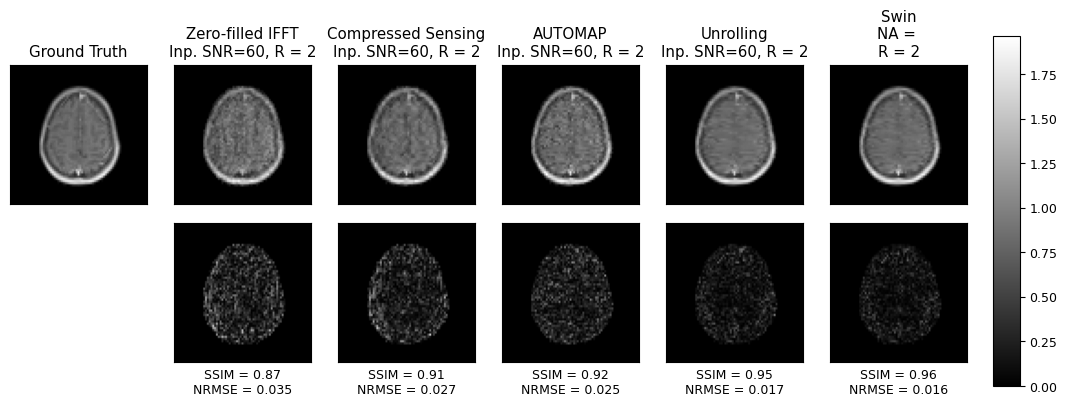

Difference Maps are scaled by 3


In [25]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol5 = np.copy(vol_swin[:,:,1:])
vol5[mask_metrics[:,:,1:]]=0
vol5title = 'Swin\nNA = '+'\nR = '+str(R)

vol1_low_R2 = vol1
vol2_low_R2 = vol2
vol3_low_R2 = vol3
vol4_low_R2 = vol4
vol5_low_R2 = vol5

slc=13

from display_fns import compare_n_plot
fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked,
    volumes=[vol1_low_R2, vol2_low_R2, vol3_low_R2, vol4_low_R2, vol5_low_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)


## High SNR

In [26]:
#test_no=125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l=-1
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [27]:
noise_val

80

In [28]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)

volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace,mask,mps, unroll_model_pth)
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)

### Background Masked

In [29]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol5 = np.copy(vol_swin[:,:,1:])
vol5[mask_metrics[:,:,1:]]=0
vol5title = 'Swin\nNA = '+'\nR = '+str(R)

vol1_high_R2 = vol1
vol2_high_R2 = vol2
vol3_high_R2 = vol3
vol4_high_R2 = vol4
vol5_high_R2 = vol5


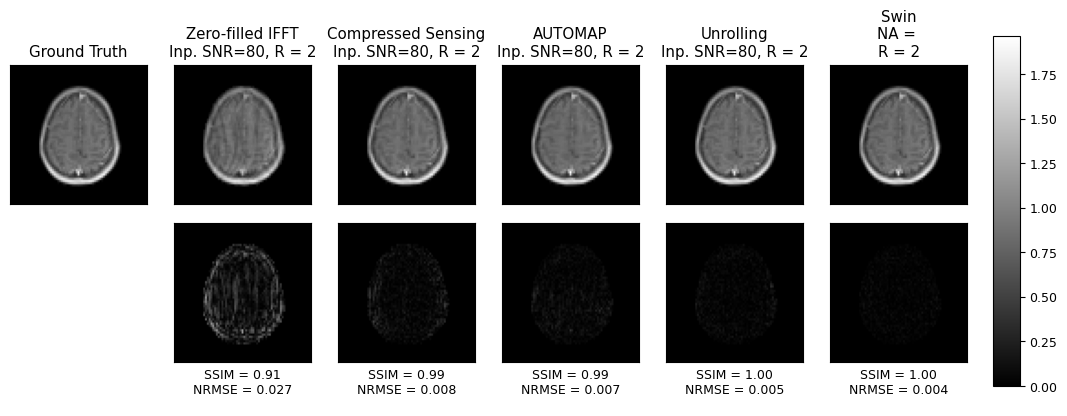

Difference Maps are scaled by 3


In [30]:
fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked,
    volumes=[vol1_high_R2, vol2_high_R2, vol3_high_R2, vol4_high_R2, vol5_high_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

In [31]:
GT_R2 = volumeGTscaledmasked

In [32]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=4
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
mask_R4 = mask

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

In [33]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'

elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'

In [34]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))

In [35]:
start = time.time()

job_args = []
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        job_args.append((j, k, noise_val, ksp_fs_sc_all, img_gt_sc_all, mask, mps, calib_size))

from joblib import Parallel, delayed

results = Parallel(n_jobs=10)(
    delayed(process_jk)(args) for args in job_args
)

lamda_opt_vals = np.zeros((len(noise_dB), n_ex_cs))
iter_opt_vals = np.zeros((len(noise_dB), n_ex_cs))

for j, k, lamda_opt, iter_opt in results:
    lamda_opt_vals[j, k] = lamda_opt
    iter_opt_vals[j, k] = iter_opt

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

end = time.time()    
print(f"Took {end - start:.2f} seconds")


/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerW

Took 102.33 seconds


In [36]:
# print("Noise (dB)   Lambda_opt        Iter_opt")
# print("------------------------------------------")
# for j, noise_val in enumerate(noise_dB_zero):
#     print(f"{noise_val:8.1f}   {lamda_opt[j]:12.4f}   {iter_opt[j]:10.2f}")

In [37]:
# Initialize metric arrays
nrmse_ifft_vals   = np.zeros((noise_dB.size, n_ex_test))
nrmse_cs_vals     = np.zeros((noise_dB.size, n_ex_test))
nrmse_amap_vals   = np.zeros((noise_dB.size, n_ex_test))
nrmse_unroll_vals = np.zeros((noise_dB.size, n_ex_test))
nrmse_swin_vals   = np.zeros((noise_dB.size, n_ex_test))

ssim_ifft_vals   = np.zeros((noise_dB.size, n_ex_test))
ssim_cs_vals     = np.zeros((noise_dB.size, n_ex_test))
ssim_amap_vals   = np.zeros((noise_dB.size, n_ex_test))
ssim_unroll_vals = np.zeros((noise_dB.size, n_ex_test))
ssim_swin_vals   = np.zeros((noise_dB.size, n_ex_test))

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
#with tf.device('/CPU:0'):
model_real = keras.models.load_model(model_real_dir)
model_imag = keras.models.load_model(model_imag_dir)

import time
# Evaluation loop
for j, noise_val in enumerate(noise_dB):
    print(j)
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:, :, :, :, k + n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:, :, :, k + n_ex_cs]

        # Add noise and apply mask
        kspInput = awgn(kspTestScaled, noise_val, L=1)
        uskspace = applyMask(kspInput, mask)

        # Reconstructions

        # Zer-filled Recon
        volifftrecon_mc = sp.ifft(uskspace, axes=[1, 2, 3])
        volifftrecon = coil_combine(volifftrecon_mc, mps)

        # L1-Wavelet CS Recon
        start = time.time()
        volcsrecon = ulfl1recon(uskspace, mask, lamda_opt[j], iter_opt[j], mps)
        end = time.time()
        #print(f"[{j}, {k}] CS Recon took {end - start:.2f} seconds")
        
        # Unrolled Recon
        start = time.time()
        _, volunrollrecon = unrolling_fns.unrollingRecon(uskspace, mask, mps, unroll_model_pth)
        end = time.time()
        #print(f"[{j}, {k}] Unrolled Recon took {end - start:.2f} seconds")
        
        # AUTOMAP Recon
        start = time.time()
        #volamaprecon, _ = automap_fns.automapRecon(uskspace, mps, model_real_dir, model_imag_dir)
        volamaprecon, _ = automap_fns.automapRecon(uskspace, mps, model_real, model_imag)
        end = time.time()
        #print(f"[{j}, {k}] AUTOMAP Recon took {end - start:.2f} seconds")
        
        # Swin Transformer Recon
        start = time.time()
        with torch.no_grad():
            vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)
        end = time.time()
        #print(f"[{j}, {k}] Swin Recon took {end - start:.2f} seconds")

        
        
        # Mask out background before metric calculations
        mask_metrics = np.ma.getmask(np.ma.masked_less(np.abs(volumeGTscaled), 0.05))
        volumeGTscaled[mask_metrics]    = 0
        volifftrecon[mask_metrics]      = 0
        volcsrecon[mask_metrics]        = 0
        volamaprecon[mask_metrics]      = 0
        volunrollrecon[mask_metrics]    = 0
        vol_swin[mask_metrics]          = 0

        # Compute NRMSE
        nrmse_ifft_vals[j, k]   = nrmse(np.abs(volifftrecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_cs_vals[j, k]     = nrmse(np.abs(volcsrecon[:, :, 1:]),     np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_amap_vals[j, k]   = nrmse(np.abs(volamaprecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_unroll_vals[j, k] = nrmse(np.abs(volunrollrecon[:, :, 1:]), np.abs(volumeGTscaled[:, :, 1:]))
        nrmse_swin_vals[j, k]   = nrmse(np.abs(vol_swin[:, :, 1:]),       np.abs(volumeGTscaled[:, :, 1:]))

        # Compute SSIM
        ssim_ifft_vals[j, k]   = ssim(np.abs(volifftrecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        ssim_cs_vals[j, k]     = ssim(np.abs(volcsrecon[:, :, 1:]),     np.abs(volumeGTscaled[:, :, 1:]))
        ssim_amap_vals[j, k]   = ssim(np.abs(volamaprecon[:, :, 1:]),   np.abs(volumeGTscaled[:, :, 1:]))
        ssim_unroll_vals[j, k] = ssim(np.abs(volunrollrecon[:, :, 1:]), np.abs(volumeGTscaled[:, :, 1:]))
        ssim_swin_vals[j, k]   = ssim(np.abs(vol_swin[:, :, 1:]),       np.abs(volumeGTscaled[:, :, 1:]))


0
1
2


In [38]:
# Compute means
nrmse_swin   = nrmse_swin_vals.mean(axis=1)
ssim_swin    = ssim_swin_vals.mean(axis=1)

# Compute standard deviations
nrmse_swin_sd = nrmse_swin_vals.std(axis=1)
ssim_swin_sd  = ssim_swin_vals.std(axis=1)

# Existing stats (unchanged)
nrmse_cs     = nrmse_cs_vals.mean(axis=1)
nrmse_ifft   = nrmse_ifft_vals.mean(axis=1)
nrmse_amap   = nrmse_amap_vals.mean(axis=1)
nrmse_unroll = nrmse_unroll_vals.mean(axis=1)

nrmse_cs_sd     = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd   = nrmse_ifft_vals.std(axis=1)
nrmse_amap_sd   = nrmse_amap_vals.std(axis=1)
nrmse_unroll_sd = nrmse_unroll_vals.std(axis=1)

ssim_cs     = ssim_cs_vals.mean(axis=1)
ssim_ifft   = ssim_ifft_vals.mean(axis=1)
ssim_amap   = ssim_amap_vals.mean(axis=1)
ssim_unroll = ssim_unroll_vals.mean(axis=1)

ssim_cs_sd     = ssim_cs_vals.std(axis=1)
ssim_ifft_sd   = ssim_ifft_vals.std(axis=1)
ssim_amap_sd   = ssim_amap_vals.std(axis=1)
ssim_unroll_sd = ssim_unroll_vals.std(axis=1)

# # Plot
# fig, ((ax1, ax3),(ax2, ax4)) = plt.subplots(2, 2)
# fig.set_size_inches(6, 6)
# fig.subplots_adjust(wspace=0.5)

# --- NRMSE Plot ---
ax2.plot(noise_dB_zero, nrmse_ifft,   '-')
ax2.plot(noise_dB_zero, nrmse_cs,     '-')
ax2.plot(noise_dB_zero, nrmse_amap,   '-')
ax2.plot(noise_dB_zero, nrmse_unroll, '-')
ax2.plot(noise_dB_zero, nrmse_swin,   '-')

ax2.set(ylabel='NRMSE', xlabel='Input SNR (dB)')
ax2.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled', 'Swin'])
ax2.fill_between(noise_dB_zero, nrmse_ifft - nrmse_ifft_sd,   nrmse_ifft + nrmse_ifft_sd,   alpha=0.25)
ax2.fill_between(noise_dB_zero, nrmse_cs - nrmse_cs_sd,       nrmse_cs + nrmse_cs_sd,       alpha=0.25)
ax2.fill_between(noise_dB_zero, nrmse_amap - nrmse_amap_sd,   nrmse_amap + nrmse_amap_sd,   alpha=0.25)
ax2.fill_between(noise_dB_zero, nrmse_unroll - nrmse_unroll_sd, nrmse_unroll + nrmse_unroll_sd, alpha=0.25)
ax2.fill_between(noise_dB_zero, nrmse_swin - nrmse_swin_sd,   nrmse_swin + nrmse_swin_sd,   alpha=0.25)
ax2.set_xticks(np.arange(noise_dB_zero[0], noise_dB_zero[-1]+10, 10))
ax2.set_yticks([0, 0.05, 0.1])

# --- SSIM Plot ---
ax4.plot(noise_dB_zero, ssim_ifft,   '-')
ax4.plot(noise_dB_zero, ssim_cs,     '-')
ax4.plot(noise_dB_zero, ssim_amap,   '-')
ax4.plot(noise_dB_zero, ssim_unroll, '-')
ax4.plot(noise_dB_zero, ssim_swin,   '-')

ax4.set(ylabel='SSIM', xlabel='Input SNR (dB)')
ax4.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled AI', 'Swin AI'])
ax4.fill_between(noise_dB_zero, ssim_ifft - ssim_ifft_sd,   ssim_ifft + ssim_ifft_sd,   alpha=0.25)
ax4.fill_between(noise_dB_zero, ssim_cs - ssim_cs_sd,       ssim_cs + ssim_cs_sd,       alpha=0.25)
ax4.fill_between(noise_dB_zero, ssim_amap - ssim_amap_sd,   ssim_amap + ssim_amap_sd,   alpha=0.25)
ax4.fill_between(noise_dB_zero, ssim_unroll - ssim_unroll_sd, ssim_unroll + ssim_unroll_sd, alpha=0.25)
ax4.fill_between(noise_dB_zero, ssim_swin - ssim_swin_sd,   ssim_swin + ssim_swin_sd,   alpha=0.25)
ax4.set_xticks(np.arange(noise_dB_zero[0], noise_dB_zero[-1]+10, 10))
ax4.set_yticks([0.8, 0.9, 1])

# Save or show as needed
# fig.savefig('export_figs/fastmri_noise_curves_R'+str(R)+'.pdf', bbox_inches='tight', dpi=300)


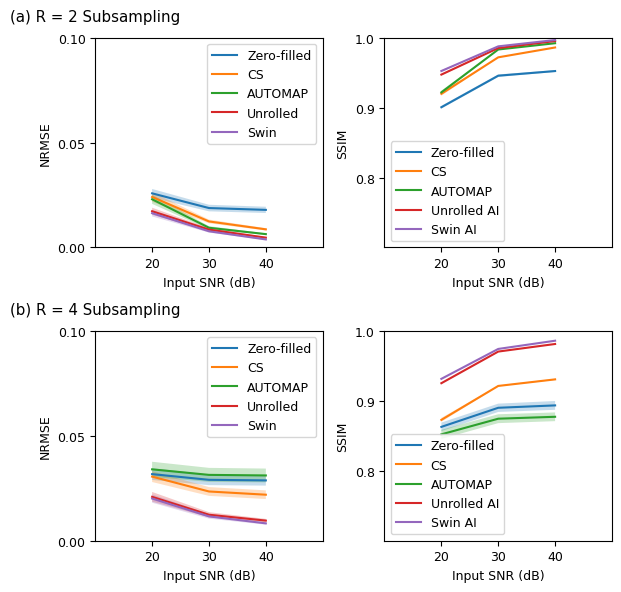

In [39]:

step=10
ax4.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax4.set_yticks([0.8,0.9,1])

ax1.set_title('(a) R = 2 Subsampling',x=0,y=1.04)
ax2.set_title('(b) R = 4 Subsampling',x=0,y=1.04)

for ax in [ax1,ax2]:
    #ax.vlines(23,0,0.1,color='tab:gray',linestyle='--')
    ax.set_ylim(0,0.1)
    ax.set_xlim(10,50)

for ax in [ax3,ax4]:
    #ax.vlines(23,0,1,color='tab:gray',linestyle='--')
    ax.set_ylim(0.7,1)
    ax.set_xlim(10,50)

fig.tight_layout()


fig.savefig('export_figs/fastmri_noise_curves_all.pdf',bbox_inches='tight',dpi=300)
fig


## Low SNR

In [40]:
test_no = 125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l = 0
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [41]:
noise_val

60

In [42]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,mps, unroll_model_pth)
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)

In [43]:
R

4

### Background Masked

In [44]:
model_real_dir

'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras'

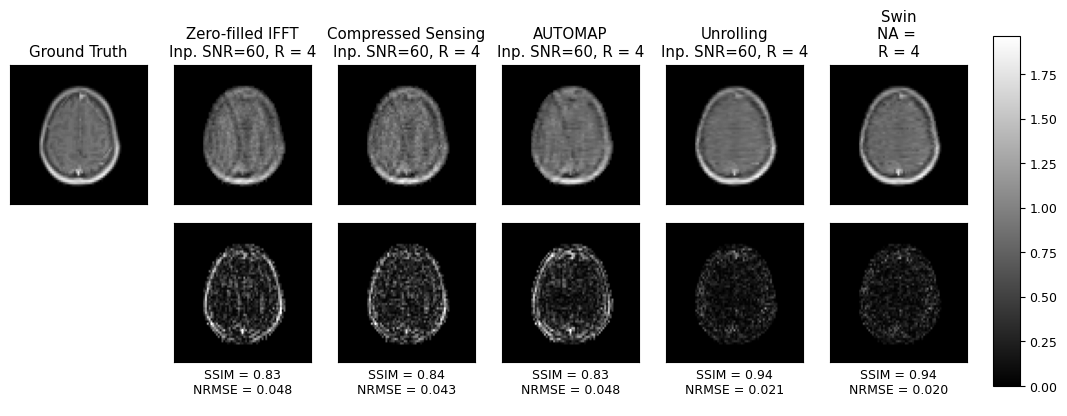

Difference Maps are scaled by 3


In [45]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol5 = np.copy(vol_swin[:,:,1:])
vol5[mask_metrics[:,:,1:]]=0
vol5title = 'Swin\nNA = '+'\nR = '+str(R)

vol1_low_R4 = vol1
vol2_low_R4 = vol2
vol3_low_R4 = vol3
vol4_low_R4 = vol4
vol5_low_R4 = vol5

slc=13

from display_fns import compare_n_plot
fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked,
    volumes=[vol1_low_R4, vol2_low_R4, vol3_low_R4, vol4_low_R4, vol5_low_R4],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)


## High SNR

In [46]:
#test_no=125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l=-1
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [47]:
noise_val

80

In [48]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)

volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace,mask,mps, unroll_model_pth)
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device_swin)
vol_swin, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device_swin)

### Background Masked

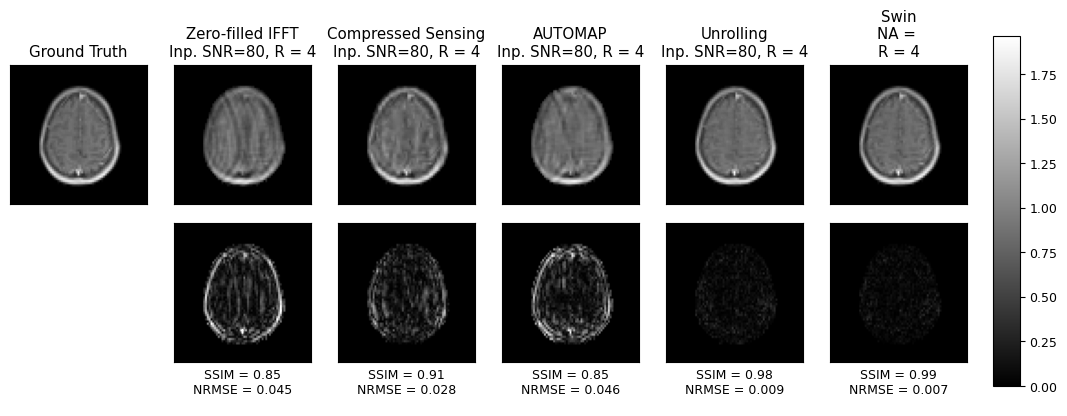

Difference Maps are scaled by 3


In [49]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol5 = np.copy(vol_swin[:,:,1:])
vol5[mask_metrics[:,:,1:]]=0
vol5title = 'Swin\nNA = '+'\nR = '+str(R)

vol1_high_R4 = vol1
vol2_high_R4 = vol2
vol3_high_R4 = vol3
vol4_high_R4 = vol4
vol5_high_R4 = vol5

slc=13

from display_fns import compare_n_plot
fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked,
    volumes=[vol1_high_R4, vol2_high_R4, vol3_high_R4, vol4_high_R4, vol5_high_R4],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)


In [50]:
GT_R4 = volumeGTscaledmasked

## Comparing images

In [51]:
slc=10

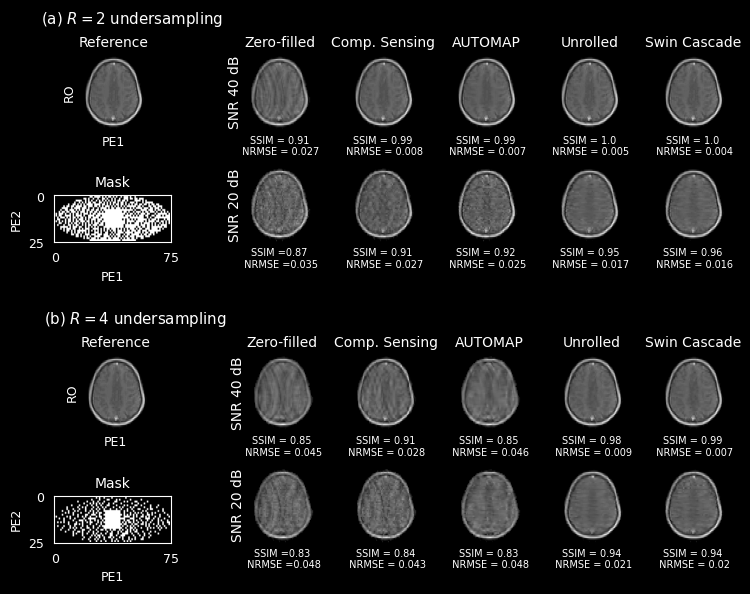

In [52]:
vol1title = 'Zero-filled'
vol2title = 'Comp. Sensing'
vol3title = 'AUTOMAP'
vol4title = 'Unrolled'
vol5title = 'Swin Cascade'

font_lw = 500

# RO 64, 2.5 mm
# PE1 75, 3.5mm
# PE2 15, 8 mm
asp_ratio = (GT_R2.shape[1]*3.5)/(GT_R2.shape[0]*2.5)

#plt.style.use('default')
plt.style.use('dark_background')


figimgs, axs = plt.subplots(4, 6, figsize=(10, 5)) 


figimgs.subplots_adjust(hspace=1.4)
figimgs.subplots_adjust(wspace=-0.6)

max_GT_R2 = np.amax(np.abs(GT_R2[:,:,slc]))

im = axs[0, 0].imshow(np.abs(GT_R2[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT_R2)

axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_aspect(asp_ratio)
axs[0, 0].set_xlabel('PE1')
axs[0, 0].set_ylabel('RO')
im.set_clim(0, (1.05*max_GT_R2))

im = axs[0, 1].imshow(np.abs(vol1_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT_R2)
axs[0, 1].set_title(vol1title,fontsize=10, fontweight=font_lw)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 1].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol1_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol1_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

axs[0, 1].set_ylabel('SNR '+str(noise_dB_zero[-1])+' dB',fontsize=10, fontweight=font_lw)

im = axs[1, 1].imshow(np.abs(vol1_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 1].set_title(vol1title + ' Diff')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 1].set_xlabel('SSIM ='+str(round(ssim(np.abs(vol1_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE ='+str(round(nrmse(np.abs(vol1_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)
axs[1, 1].set_ylabel('SNR '+str(noise_dB_zero[0])+' dB',fontsize=10, fontweight=font_lw)


im = axs[0, 2].imshow(np.abs(vol2_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 2].set_title(vol2title, fontsize=10, fontweight=font_lw)
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
axs[0, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 2].imshow(np.abs(vol2_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 2].set_title(vol2title + ' Diff')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
axs[1, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[0, 3].imshow(np.abs(vol3_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 3].set_title(vol3title, fontsize=10, fontweight=font_lw)
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])
axs[0, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 3].imshow(np.abs(vol3_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 3].set_title(vol3title + ' Diff')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
axs[1, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[0, 4].imshow(np.abs(vol4_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 4].set_title(vol4title, fontsize=10, fontweight=font_lw)
axs[0, 4].set_xticks([])
axs[0, 4].set_yticks([])
axs[0, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 4].imshow(np.abs(vol4_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 4].set_title(vol4title + ' Diff')
axs[1, 4].set_xticks([])
axs[1, 4].set_yticks([])
axs[1, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)


im = axs[1,0].imshow(np.abs(mask_R2.T),cmap='gray')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_xlabel('PE1')
axs[1, 0].set_ylabel('PE2')
axs[1, 0].set_title('Mask',fontsize=10, fontweight=font_lw)
#axs[1, 0].axis('off')




max_GT_R4 = np.amax(np.abs(GT_R4[:,:,slc]))

im = axs[2, 0].imshow(np.abs(GT_R4[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT_R4)

axs[2, 0].set_xlabel('PE1')
axs[2, 0].set_ylabel('RO')
im.set_clim(0, (1.05*max_GT_R4))

im = axs[2, 1].imshow(np.abs(vol1_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT_R4)
axs[2, 1].set_title(vol1title,fontsize=10,fontweight=font_lw)
im.set_clim(0, (1.05*max_GT_R4))
axs[2, 1].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol1_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol1_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)
axs[2, 1].set_ylabel('SNR '+str(noise_dB_zero[-1])+' dB',fontsize=10, fontweight=font_lw)

im = axs[3, 1].imshow(np.abs(vol1_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 1].set_title(vol1title + ' Diff')
im.set_clim(0, (1.05*max_GT_R4))
axs[3, 1].set_xlabel('SSIM ='+str(round(ssim(np.abs(vol1_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE ='+str(round(nrmse(np.abs(vol1_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)
axs[3, 1].set_ylabel('SNR '+str(noise_dB_zero[0])+' dB',fontsize=10, fontweight=font_lw)


im = axs[2, 2].imshow(np.abs(vol2_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 2].set_title(vol2title,fontsize=10,fontweight=font_lw)
im.set_clim(0, (1.05*max_GT_R4))
axs[2, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 2].imshow(np.abs(vol2_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 2].set_title(vol2title + ' Diff')
im.set_clim(0, (1.05*max_GT_R4))
axs[3, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[2, 3].imshow(np.abs(vol3_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 3].set_title(vol3title,fontsize=10,fontweight=font_lw)

im.set_clim(0, (1.05*max_GT_R4))
axs[2, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 3].imshow(np.abs(vol3_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 3].set_title(vol3title + ' Diff')

im.set_clim(0, (1.05*max_GT_R4))
axs[3, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[2, 4].imshow(np.abs(vol4_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 4].set_title(vol4title,fontsize=10,fontweight=font_lw)

im.set_clim(0, (1.05*max_GT_R4))
axs[2, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 4].imshow(np.abs(vol4_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 4].set_title(vol4title + ' Diff')

im.set_clim(0, (1.05*max_GT_R4))
axs[3, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

# --- vol5 R=2 (row 0 and 1, col 5) ---
im = axs[0, 5].imshow(np.abs(vol5_high_R2[:, :, slc].T), cmap='gray', vmin=0, vmax=1.05*max_GT_R2)
axs[0, 5].set_title(vol5title, fontsize=10, fontweight=font_lw)
axs[0, 5].set_xticks([])
axs[0, 5].set_yticks([])
axs[0, 5].set_aspect(asp_ratio)
im.set_clim(0, 1.05*max_GT_R2)
axs[0, 5].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol5_high_R2), np.abs(GT_R2)),2)) +
                     '\n NRMSE = '+str(round(nrmse(np.abs(vol5_high_R2), np.abs(GT_R2)),3)), fontsize=7)

im = axs[1, 5].imshow(np.abs(vol5_low_R2[:, :, slc].T), cmap='gray', vmin=0, vmax=1.05*max_GT_R2)
axs[1, 5].set_xticks([])
axs[1, 5].set_yticks([])
axs[1, 5].set_aspect(asp_ratio)
im.set_clim(0, 1.05*max_GT_R2)
axs[1, 5].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol5_low_R2), np.abs(GT_R2)),2)) +
                     '\n NRMSE = '+str(round(nrmse(np.abs(vol5_low_R2), np.abs(GT_R2)),3)), fontsize=7)

# --- vol5 R=4 (row 2 and 3, col 5) ---
im = axs[2, 5].imshow(np.abs(vol5_high_R4[:, :, slc].T), cmap='gray', vmin=0, vmax=1.05*max_GT_R4)
axs[2, 5].set_title(vol5title, fontsize=10, fontweight=font_lw)
axs[2, 5].set_xticks([])
axs[2, 5].set_yticks([])
axs[2, 5].set_aspect(asp_ratio)
im.set_clim(0, 1.05*max_GT_R4)
axs[2, 5].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol5_high_R4), np.abs(GT_R4)),2)) +
                     '\n NRMSE = '+str(round(nrmse(np.abs(vol5_high_R4), np.abs(GT_R4)),3)), fontsize=7)

im = axs[3, 5].imshow(np.abs(vol5_low_R4[:, :, slc].T), cmap='gray', vmin=0, vmax=1.05*max_GT_R4)
axs[3, 5].set_xticks([])
axs[3, 5].set_yticks([])
axs[3, 5].set_aspect(asp_ratio)
im.set_clim(0, 1.05*max_GT_R4)
axs[3, 5].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol5_low_R4), np.abs(GT_R4)),2)) +
                     '\n NRMSE = '+str(round(nrmse(np.abs(vol5_low_R4), np.abs(GT_R4)),3)), fontsize=7)



im = axs[3,0].imshow(np.abs(mask_R4.T),cmap='gray')
axs[3, 0].set_xlabel('PE1')
axs[3, 0].set_ylabel('PE2')
axs[3, 0].set_title('Mask',fontsize=10,fontweight=font_lw)



img_scale = 1.6

for j in range(4):
    for k in range(6):
        l, b, w, h = axs[j,k].get_position().bounds
        axs[j,k].set_position([l,b,w*img_scale,h*img_scale])
        if j>1:
            axs[j,k].set_position([l,b-0.15,w*img_scale,h*img_scale])

col0shift=-0.05
col_delta=-0.013

axs[0, 0].set_title('Reference',fontsize=10, fontweight=font_lw)
axs[2, 0].set_title('Reference',fontsize=10,fontweight=font_lw)

l, b, w, h = axs[0,0].get_position().bounds
axs[0, 0].set_position([l+col0shift+col_delta,b,w,h])

l, b, w, h = axs[1,0].get_position().bounds
axs[1, 0].set_position([l+col0shift,b,w,h])

l, b, w2, h2 = axs[1,0].get_position().bounds
axs[1,0].set_position([l,b,w2/img_scale,h2/img_scale])

l, b, w, h = axs[2, 0].get_position().bounds
axs[2, 0].set_position([l+col0shift+col_delta,b,w,h])

l, b, w2, h2 = axs[3,0].get_position().bounds
axs[3,0].set_position([l,b,w2/img_scale,h2/img_scale])

l, b, w, h = axs[3,0].get_position().bounds
axs[3, 0].set_position([l+col0shift,b,w,h])

axs[1, 1].set_title('(a) $R = 2$ undersampling',x=-1.8,y=2.8,fontweight=font_lw)
axs[3, 1].set_title('(b) $R = 4$ undersampling',x=-1.8,y=2.8,fontweight=font_lw)

for ax in axs.flatten():

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(asp_ratio)
    ax.tick_params(color='k')
    if ax not in [axs[1,0],axs[3,0]]:
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
        ax.set_xlim([10,65])
        ax.set_ylim([59,5])

for ax in [axs[1,0],axs[3,0]]:
    #for spine in ax.spines.values():
    #    spine.set_edgecolor('w')
    ax.set_xticks([0,75])
    ax.set_yticks([0,25])
    #ax.set_xlim([])
    #ax.set_ylim([])

figimgs.savefig('export_figs/fastmri_imgs_compare_snr_R.pdf',bbox_inches='tight',dpi=300)